# Всякие статистические штуки

https://proglib.io/p/40-voprosov-po-statistike-s-sobesedovaniya-na-dolzhnost-data-scientist-2020-09-24

https://www.tutorialspoint.com/online_latex_editor.php

## init

In [1]:
import pandas as pd
import numpy as np

from scipy import stats

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from matplotlib import pyplot as plt


%matplotlib inline

In [2]:
# украшаем графики
plt.rcParams["figure.figsize"] = (17,8) # размер
plt.style.use('ggplot')                 # модный стиль

## 3. Центральная предельная теорема

Вообще, она говорит о сумме. Типа пусть у нас есть n независимых одинаково распределённых случайных величин с мат. ожиданием $ \mu $ и дисперсией $ \sigma^{2} $ , тогда их сумма имеет нормальное распределение, близкое к $N(n\mu, n\sigma^{2})$.  

Но для нас важнее другое: если мы берем выборочное среднее этих n величин $\bar{X}_{n} = \frac{1}{N} \sum_{i=1}^n X_{i}$, то $\bar{X}_{n}$ имеет распределение, близкое к $N(\mu, \frac{\sigma^{2}}{n})$.  


Вот отсюда ноги растут у стандартной ошибки среднего, доверительных интервалов и т.п. Знакомые формулки: среднее равно $\mu$, дисперсия - $\frac{\sigma^{2}}{n})$, а значит стандартная ошибка - $\sqrt{\frac{\sigma^{2}}{n}} = \frac{\sigma}{\sqrt{n}}$.

Итак, еще раз: какова бы ни была форма распределения генеральной совокупности, выборочное распределение стремится к нормальному, а его дисперсия задается центральной предельной теоремой. Если мы набираем из генеральной совокупности (с мат. ожиданием $ \mu $ и стандартным отклонением $ \sigma $) сэмплы размера n, то средние этих выборок распределятся нормально вокруг $ \mu $ со стандартным отклонением $\frac{\sigma}{\sqrt{n}}$

In [3]:
def plot_central_limit_theorem(general_distribution, samples_n, experiments_count):
    """"""
    experiments_means = []
    
    for _ in range(experiments_count):
        sample = general_distribution.rvs(size=samples_n) # берем сэмпл размера samples_n из general_distribution
        experiments_means.append(np.mean(sample)) # добавляем выборочное среднее этого сэмпла в experiments_means
        
    # general distribution
    general_x = np.linspace(general_distribution.ppf(0.01), general_distribution.ppf(0.99), 100)
    general_y = general_distribution.pdf(general_x)
        
    # theoretical distribution
    theoretical_distribution = stats.norm(
        general_distribution.mean(),
        general_distribution.std()/samples_n**(1/2)
    )
    
    theoretical_x = np.linspace(theoretical_distribution.ppf(0.01), theoretical_distribution.ppf(0.99), 100)
    theoretical_y = theoretical_distribution.pdf(theoretical_x)
    
    # plots
    ax = plt.axes()
    ax.plot(general_x, general_y, label='general distribution pdf')
    ax.plot(theoretical_x, theoretical_y, label='theoretical distribution pdf')
    ax.hist(experiments_means, density=True, label='experiments hist')
    ax.legend()
    plt.show();

In [4]:
interact(
    plot_central_limit_theorem, 
    general_distribution=fixed(stats.lognorm(0.7)),
    samples_n=30,
    experiments_count=50
);

interactive(children=(IntSlider(value=30, description='samples_n', max=90, min=-30), IntSlider(value=50, descr…

Видим, что распределение генеральной совокупности далеко от нормального. Но когда мы берем из нее  `experiments_count` сэмплов по `samples_n` штук, мы получаем близкую к $N(\mu, \frac{\sigma^{2}}{n})$ (`theoretical distribution`) гистограмму средних этих сэмплов. И чем больше экспериментов - тем гистограмма ближе к теоретическому распределению.

## 10. сравнение распределений

Вот есть у нас данные. Хотим мы их промоделировать каким-то распределением. Как понять, правильно ли мы подобрали распределение?  

Для нормальности есть тест Шипиро-Вилка. А для других?

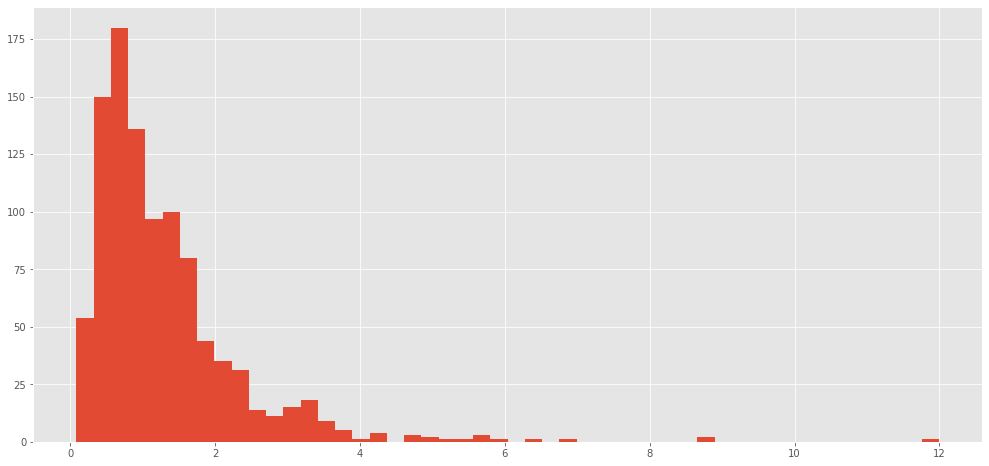

In [48]:
sample_data = pd.Series(stats.lognorm(s=0.7, scale=1).rvs(size=1000))

sample_data.hist(bins=50);

Ну, глянули на гистограмму - можно делать предположения о распределении. Но еще надо найти его параметры. Нетривиальная задачка. Для `lognorm` это будет так:

In [49]:
y = np.log(sample_data) # логарифм наших логнормальных данных (распределен нормально)

mu = y.mean() # берем свойства выборки как свойства распределения
std = y.std() # ерем свойства выборки как свойства распределения

print(f"Предполагаемый s: {std}; scale: {np.exp(mu)}") 

distribution = stats.lognorm(s=std, scale=np.exp(mu))

Предполагаемый s: 0.7039106128360694; scale: 0.9998473736622712


### гистограмма + pdf распределения

вариант очевидный. Сделать можно так:

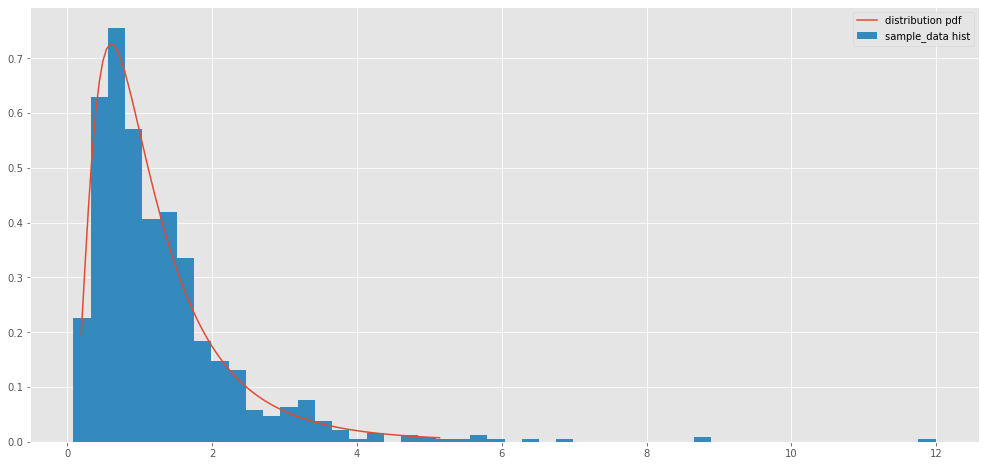

In [50]:
x = np.linspace(distribution.ppf(0.01), distribution.ppf(0.99), 100)
y = distribution.pdf(x)

ax = plt.axes()
ax.plot(x, y, label='distribution pdf')
ax.hist(sample_data, bins=50, density=True, label='sample_data hist')
ax.legend()
plt.show();

### QQ-plot

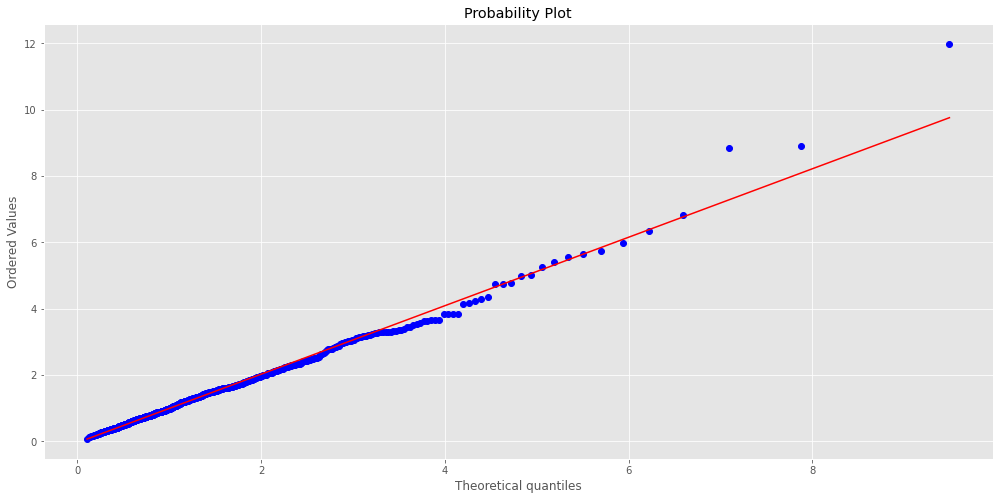

In [51]:
ax = plt.axes()

res = stats.probplot(sample_data, dist=distribution, plot=ax)

plt.show()

Смысл такой: на линии - соответствует распределению, нет - косяк. Тут если выбросы удбрать - ваще норм будет.  
    
Вообще, этот график подходит и для сравнения распределений в двух выборках. Методика такая: 

In [67]:
n = sample_data.shape[0]

quantiles = [(n-k)/n for k in range(1, n)] # какие квантили берем. По сути все, кроме 0 и 1 (k=0 и k=n)

quantiles_df = pd.DataFrame(index=quantiles)

In [68]:
quantiles_df['sample_data_quantiles'] = sample_data.quantile(quantiles)

quantiles_df.head()

,sample_data_quantiles
0.999,8.898702
0.998,8.833345
0.997,6.837265
0.996,6.342422
0.995,5.986980


In [69]:
quantiles_df['distrib_quantiles'] = distribution.ppf(quantiles)

quantiles_df.head()

,sample_data_quantiles,distrib_quantiles
0.999,8.898702,8.803019
0.998,8.833345,7.582295
0.997,6.837265,6.917399
0.996,6.342422,6.466710
0.995,5.986980,6.128812


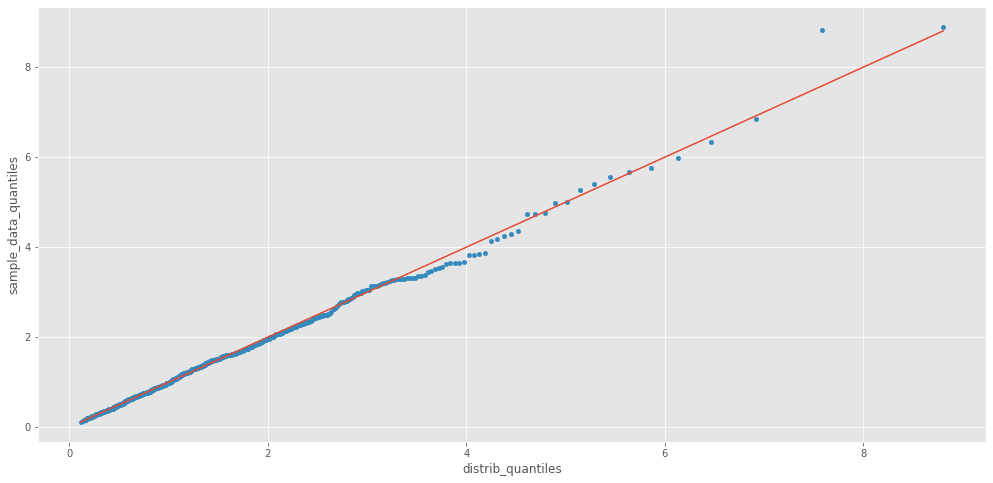

In [72]:
ax = quantiles_df.plot.scatter('distrib_quantiles', 'sample_data_quantiles')
ax.plot(quantiles_df['distrib_quantiles'], quantiles_df['distrib_quantiles']) # как должно быть

plt.show();

Т.е. ничто не мешает вместо `ppf` распределения взять такие же фактические квантили другого сэмпла.

## Какие есть распределения

https://habr.com/ru/post/311092/

## Байес

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$